# 0. Import Data from Kaggle

In [4]:
# Install the kaggle API
!pip install kaggle

In [5]:
# Upload kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emrecanakgz","key":"e310b0f392d40429787a16c5e91a85fd"}'}

In [6]:
# Move the kaggle.json file into ~/.kaggle, which is where the API client expects your token to be located
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Give permissions to change avoids a warning on Kaggle tool startup
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Download dataset
!kaggle competitions download -c digit-recognizer --force


 55% 5.00M/9.16M [00:00<00:00, 32.2MB/s]
100% 9.16M/9.16M [00:00<00:00, 45.0MB/s]
  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 55.5MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 74.0MB/s]


In [8]:
# unzip training set to `train` folder
#!mkdir train.csv
#!unzip train.csv.zip -d train

# unzip test set to `test` folder
#!mkdir test.csv
#!unzip test.csv.zip -d test


In [9]:
from zipfile import ZipFile
file_name1 = "train.csv.zip"
file_name2 = "test.csv.zip"

with ZipFile(file_name1, 'r') as zip:
  zip.extractall()
  print("Done-1 !")

with ZipFile(file_name2, 'r') as zip:
  zip.extractall()
  print("Done-2 !")

Done-1 !
Done-2 !


# 1. Import Libraries

In [10]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.utils import plot_model

from sklearn.model_selection import train_test_split

from IPython.display import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [11]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 2. Import Dataset

In [12]:
Train = pd.read_csv("digit-recognizer/train.csv")
Test = pd.read_csv("digit-recognizer/test.csv")
sample_submission = pd.read_csv("digit-recognizer/sample_submission.csv")

print("OK!")

OK!


In [13]:
print("Train shape: {}".format(Train.shape))
print("Test shape: {}".format(Test.shape))
print("Submission shape: {}".format(sample_submission.shape))

Train shape: (42000, 785)
Test shape: (28000, 784)
Submission shape: (28000, 2)


# 3. Data Modifications

In [14]:
# Drop labels from Training Set
X = Train.drop(['label'], 1).values
# Create labels
y = Train['label'].values

X_Test = Test.values

# Scale Pixels
X = X / 255.0
X_Test = X_Test / 255.0

print("X shape: {}".format(X.shape))
print("X_Test shape: {}".format(X_Test.shape))

X shape: (42000, 784)
X_Test shape: (28000, 784)


In [15]:
# Reshape image (height = 28, width = 28 , canal = 1 [GRAY])
X = X.reshape(-1,28,28,1)
X_Test = X_Test.reshape(-1,28,28,1)

# One-Hot encoding for labels
y = to_categorical(y, num_classes=10)

In [16]:
# Split data
random_state = 18

training_images, validation_images, training_labels, validation_labels = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=random_state)

In [17]:
print(training_images.shape)
print(validation_images.shape)
print(training_labels.shape)
print(validation_labels.shape)

(35700, 28, 28, 1)
(6300, 28, 28, 1)
(35700, 10)
(6300, 10)


# 4. Training

### 4.1 Network

In [19]:
# Network architecture (GPU Support!)
with tf.device('/gpu:0'):
  model = tf.keras.models.Sequential([
      
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

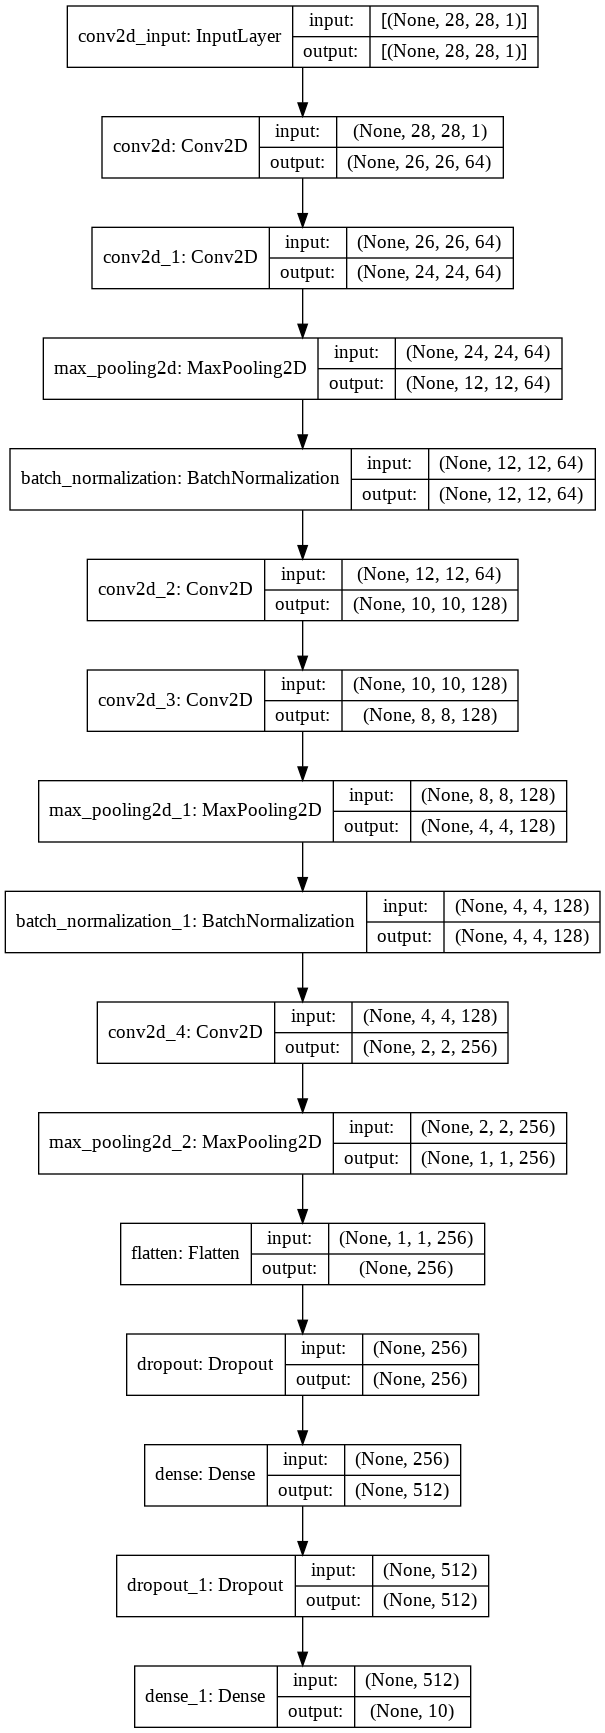

In [20]:
# Show Architecture
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image("model.png")

### 4.2 Training Bias

In [24]:
# Parameters
epochs = 100
batch_size = 64
num_train_sumples = training_images.shape[0] 
num_val_sumples = validation_images.shape[0]
optimizer = 'adam' #RMSprop with appropriate lr,beta can increase Acc => Try Grid Search with TPU
loss = "categorical_crossentropy"

In [25]:
# Set optimizer and loss function
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Data Augmantation
train_datagen = ImageDataGenerator(
       rotation_range=10,
       width_shift_range=0.1,
       height_shift_range=0.1,
       zoom_range=0.1,
       horizontal_flip=False,
       vertical_flip=False)


train_generator = train_datagen.flow(training_images, training_labels, batch_size=batch_size)
validation_generator = train_datagen.flow(validation_images, validation_labels, batch_size=batch_size)

### 4.3 Train

In [26]:
# Train
history = model.fit(train_generator, 
                    steps_per_epoch = num_train_sumples // batch_size, 
                    validation_data = validation_generator, 
                    validation_steps = num_val_sumples // batch_size, 
                    epochs=epochs)

Epoch 1/100
557/557 [==============================] - 13s 21ms/step - loss: 0.0559 - accuracy: 0.9849 - val_loss: 0.0440 - val_accuracy: 0.9887
Epoch 2/100
557/557 [==============================] - 12s 21ms/step - loss: 0.0595 - accuracy: 0.9848 - val_loss: 0.0351 - val_accuracy: 0.9900
Epoch 3/100
557/557 [==============================] - 12s 21ms/step - loss: 0.0471 - accuracy: 0.9876 - val_loss: 0.0373 - val_accuracy: 0.9895
Epoch 4/100
557/557 [==============================] - 12s 21ms/step - loss: 0.0488 - accuracy: 0.9871 - val_loss: 0.0452 - val_accuracy: 0.9885
Epoch 5/100
557/557 [==============================] - 12s 21ms/step - loss: 0.0406 - accuracy: 0.9888 - val_loss: 0.0330 - val_accuracy: 0.9915
Epoch 6/100
557/557 [==============================] - 12s 21ms/step - loss: 0.0382 - accuracy: 0.9898 - val_loss: 0.0383 - val_accuracy: 0.9898
Epoch 7/100
557/557 [==============================] - 12s 21ms/step - loss: 0.0383 - accuracy: 0.9892 - val_loss: 0.0240 - val_ac

# 5. Training & Validation Curves

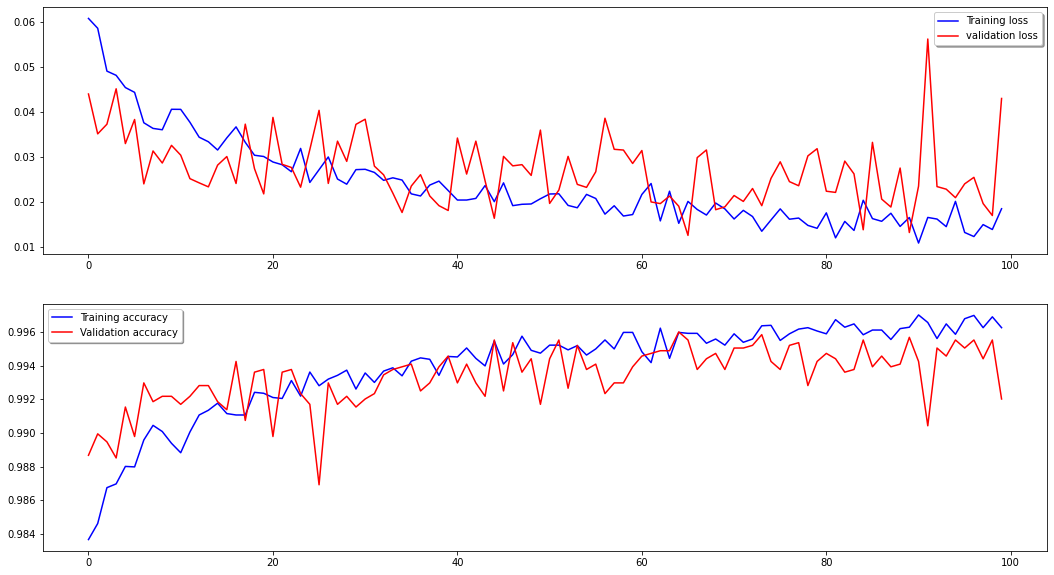

In [27]:
# Plot the loss and accuracy curves
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# 6. Testing

In [28]:
# Confussion Matrix
y_predict = model.predict(validation_images)

y_predicted = np.argmax(y_predict, axis = 1) + 1
Y_test = np.argmax(validation_labels, axis = 1) + 1
confusion_matrix = pd.crosstab(y_predicted, Y_test, rownames = ['y_predicted'], colnames = ['y_test'])
print(confusion_matrix)

y_test        1    2    3    4    5    6    7    8    9    10
y_predicted                                                  
1            618    0    1    0    0    0    6    0    4    2
2              0  706    0    0    0    0    0    0    0    0
3              0    0  607    0    0    0    1    0    0    0
4              0    0    0  629    0    0    0    0    1    0
5              0    3    0    0  621    0    0    0    0    0
6              1    0    0    1    0  571    1    1    0    1
7              0    0    0    0    0    1  610    0    0    0
8              0    3    1    0    0    0    0  671    0    0
9              0    0    0    2    0    1    0    0  583    0
10             0    0    0    0   10    0    0    0    0  643


In [29]:
# Classification for Test
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(Y_test, y_predicted, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99       619
     Class 1       1.00      0.99      1.00       712
     Class 2       1.00      1.00      1.00       609
     Class 3       1.00      1.00      1.00       632
     Class 4       1.00      0.98      0.99       631
     Class 5       0.99      1.00      0.99       573
     Class 6       1.00      0.99      0.99       618
     Class 7       0.99      1.00      1.00       672
     Class 8       0.99      0.99      0.99       588
     Class 9       0.98      1.00      0.99       646

    accuracy                           0.99      6300
   macro avg       0.99      0.99      0.99      6300
weighted avg       0.99      0.99      0.99      6300



# 7. Submit

In [30]:
# predict results
results = y_predict

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [31]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission_output.csv",index=False)